# 3章 Word2vec

## 3.1 推論ベースの手法とニューラルネットワーク

### 3.1.1 カウントベースの手法の問題点

カウントベースの手法では大規模なコーパスを扱う場合に問題が発生する．計算量が多すぎてキャパオーバーになる．

カウントベースが学習データを一度にまとめて処理するのに対して，推論ベースの手法は学習データの一部を使って逐次的に学習する．つまりデータを小分けにする．（ミニバッチで学習する）そしてニューラルネットワークの学習は複数マシン/複数GPUの利用による並列計算も可能なので，全体の学習も高速化できる．

### 3.1.2 推論ベースの手法の概要

コンテキストを入力としてモデル（ニューラルネットワーク）を通じて各単語の出現確率を出力する．この枠組みの中で正しい推測ができるように，コーパスを使ってモデルの学習を行う．

その学習の結果として単語の分散表現を得られるというのが推論ベースの手法の全体図になる．

### 3.1.3 ニューラルネットワークにおける単語の処理方法

ニューラルネットワークの中では単語をそのまま文字列としては扱えないので，one-hot表現を用いる．

単語をベクトルで表現できるということはすなわち，そのベクトルはニューラルネットワークを構成するレイヤとして考えられることになる．

ディープラーニングのフレームワークでは，全結合層の生成時にバイアスを用いないような選択ができる．今回はバイアスを省略．

In [3]:
# ここまでの話をコードで実装

import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 入力
W = np.random.randn(7, 3)              # 重み
print(W)
h = np.dot(c, W)                       # 中間ノード
print(h)

[[ 1.78712386  1.21221821  0.77690671]
 [-0.57255538  0.84700939 -0.53853318]
 [ 0.94835959  0.39010704 -0.05828024]
 [ 0.01839848  1.27450426 -0.57851938]
 [-1.22962531  0.83934524 -0.41959013]
 [ 1.45337477 -0.53299252 -0.67785329]
 [ 0.71606151 -0.57410542  1.48549478]]
[[1.78712386 1.21221821 0.77690671]]


In [5]:
# MatMulレイヤで同様の処理を実装

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.54428162 -0.23365602  0.52056395]]


## 3.2 シンプルなword2vec

ここからはword2vecの実装に取り掛かる．

具体的には，ここまで見てきたモデルに取り入れるニューラルネットワークにword2vecで提案されているcontinuous bag-of-words(CBOW)と呼ばれるモデルを使う．

### 3.2.1 CBOWモデルの推論処理

#### CBOWモデル
コンテキストからターゲットを推測することを目的としたニューラルネットワーク．入力はコンテキスト，コンテキストの数に応じて入力層の数は変化する．中間層にあるニューロンの値は各入力層全結合による変換後の値の平均値をとる．出力層のニューロンは各単語に対応している．出力層にニューロンは各単語のスコアであり，softmax関数を使用してそれを確率に変換する．全結合層に重み7×3の行列は，単語の分散表現であり，学習を重ねることで，コンテキストから出現する単語をうまく推測できるように，各単語の分散表現が更新される．

- エンコード：人間には理解できないコード
- デコード：エンコードされた情報を，人間が理解できる表現へに復元する作業

#### レイヤ視点でCBOWモデルを考える
最初に入力層の数だけMatMulレイヤがあり，それぞれを加算する．そして加算された値の平均を求めて中間層のニューロンとする．最後に中間層に対してもMatMulレイヤが適用されスコアを出力する．

In [6]:
# CBOWモデルの推論処理を実装

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 1.92983489 -0.35052161  0.15652616 -1.59789654 -0.66392563  0.04142847
  -0.39454069]]


### 3.2.2 CBOWモデルの学習

CBOWモデルの学習で行うことは正しい予測ができるように重みを調整すること．単語の出現パターンを捉えたベクトルが学習される．

CBOWモデルはコーパスにおける単語の出現パターンを学ぶだけなので，コーパスが違えば，学習で得られる単語の分散表現は異なる．

学習はシンプルで，スコアをSoftmaxで確率に変換し，教師ラベルと比較して交差エントロピー誤差を求め，損失を出す．損失を用いて学習を行う．

### 3.2.3 word2vecの重みと分散表現

word2vecで使用されるネットワークには2つの重みがある．入力側の重みの各行は単語の分散表現を表し，出力側の重みも同様に単語の意味がエンコードされた重みが格納されている．ただし出力側は各行ではなく，各列に単語の分散表現が格納されている．

## 3.3 学習データの準備

### 3.3.1 コンテキストとターゲット

In [11]:
# コーパスからコンテキストとターゲットを作成する
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

# ======================================================================
print("="*80)
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

# ======================================================================
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 one-hot表現への変換

In [13]:
# コンテキストとターゲットのone-hot変換を含めてここまでの処理を実装
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## 3.4 CBOWモデルの実装

In [17]:
# ニューラルネットワークの実装
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    # 順伝播
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer0.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    # 逆伝播
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 学習コードの実装

CBOWモデルの学習は通常のニューラルネットワークの学習と全く同じ．まずは学習データを準備して，ニューラルネットワークに与える．そして勾配を求めて重みパラメータを逐次アップデートする．パラメータの更新を行う方法には，SGDやAdaGradなど有名な手法がいくつかあるが，Adamというアルゴリズムを今回は使用する．

| epoch 1 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 2 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 3 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 4 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 5 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 6 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 7 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 8 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 9 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 10 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 11 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 12 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 13 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 14 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 15 |  iter 1 / 6 | time 0[s] | loss 2.83
| epoch 16 |  iter 1 / 6 | time 0[s] | loss 2.82
| epoch 17 |  iter 1 / 6 | time 0[s] | loss 2.82
| epoch 18 |  iter 1 / 6 | time 0[s] | loss 2.82
| epoch 19 |  iter 1 / 6 | time 0[s] | loss 2.82
| epoch 20 |  iter 1 / 6 | time 0[s] | loss 2.82
| epoch 21 |  iter 1 / 6 | ti

| epoch 197 |  iter 1 / 6 | time 0[s] | loss 1.33
| epoch 198 |  iter 1 / 6 | time 0[s] | loss 1.30
| epoch 199 |  iter 1 / 6 | time 0[s] | loss 1.19
| epoch 200 |  iter 1 / 6 | time 0[s] | loss 1.29
| epoch 201 |  iter 1 / 6 | time 0[s] | loss 1.29
| epoch 202 |  iter 1 / 6 | time 0[s] | loss 1.31
| epoch 203 |  iter 1 / 6 | time 0[s] | loss 1.20
| epoch 204 |  iter 1 / 6 | time 0[s] | loss 1.20
| epoch 205 |  iter 1 / 6 | time 0[s] | loss 1.33
| epoch 206 |  iter 1 / 6 | time 0[s] | loss 1.21
| epoch 207 |  iter 1 / 6 | time 0[s] | loss 1.26
| epoch 208 |  iter 1 / 6 | time 0[s] | loss 1.27
| epoch 209 |  iter 1 / 6 | time 0[s] | loss 1.13
| epoch 210 |  iter 1 / 6 | time 0[s] | loss 1.29
| epoch 211 |  iter 1 / 6 | time 0[s] | loss 1.26
| epoch 212 |  iter 1 / 6 | time 0[s] | loss 1.11
| epoch 213 |  iter 1 / 6 | time 0[s] | loss 1.24
| epoch 214 |  iter 1 / 6 | time 0[s] | loss 1.21
| epoch 215 |  iter 1 / 6 | time 0[s] | loss 1.14
| epoch 216 |  iter 1 / 6 | time 0[s] | loss 1.28


| epoch 394 |  iter 1 / 6 | time 1[s] | loss 0.64
| epoch 395 |  iter 1 / 6 | time 1[s] | loss 0.67
| epoch 396 |  iter 1 / 6 | time 1[s] | loss 0.77
| epoch 397 |  iter 1 / 6 | time 1[s] | loss 0.66
| epoch 398 |  iter 1 / 6 | time 1[s] | loss 0.69
| epoch 399 |  iter 1 / 6 | time 1[s] | loss 0.68
| epoch 400 |  iter 1 / 6 | time 1[s] | loss 0.69
| epoch 401 |  iter 1 / 6 | time 1[s] | loss 0.69
| epoch 402 |  iter 1 / 6 | time 1[s] | loss 0.68
| epoch 403 |  iter 1 / 6 | time 1[s] | loss 0.77
| epoch 404 |  iter 1 / 6 | time 1[s] | loss 0.78
| epoch 405 |  iter 1 / 6 | time 1[s] | loss 0.65
| epoch 406 |  iter 1 / 6 | time 1[s] | loss 0.64
| epoch 407 |  iter 1 / 6 | time 1[s] | loss 0.72
| epoch 408 |  iter 1 / 6 | time 1[s] | loss 0.65
| epoch 409 |  iter 1 / 6 | time 1[s] | loss 0.70
| epoch 410 |  iter 1 / 6 | time 1[s] | loss 0.63
| epoch 411 |  iter 1 / 6 | time 1[s] | loss 0.75
| epoch 412 |  iter 1 / 6 | time 1[s] | loss 0.63
| epoch 413 |  iter 1 / 6 | time 1[s] | loss 0.72


| epoch 588 |  iter 1 / 6 | time 1[s] | loss 0.47
| epoch 589 |  iter 1 / 6 | time 1[s] | loss 0.47
| epoch 590 |  iter 1 / 6 | time 1[s] | loss 0.51
| epoch 591 |  iter 1 / 6 | time 1[s] | loss 0.48
| epoch 592 |  iter 1 / 6 | time 1[s] | loss 0.53
| epoch 593 |  iter 1 / 6 | time 1[s] | loss 0.35
| epoch 594 |  iter 1 / 6 | time 1[s] | loss 0.46
| epoch 595 |  iter 1 / 6 | time 1[s] | loss 0.48
| epoch 596 |  iter 1 / 6 | time 1[s] | loss 0.56
| epoch 597 |  iter 1 / 6 | time 1[s] | loss 0.36
| epoch 598 |  iter 1 / 6 | time 1[s] | loss 0.55
| epoch 599 |  iter 1 / 6 | time 1[s] | loss 0.47
| epoch 600 |  iter 1 / 6 | time 1[s] | loss 0.43
| epoch 601 |  iter 1 / 6 | time 1[s] | loss 0.50
| epoch 602 |  iter 1 / 6 | time 1[s] | loss 0.42
| epoch 603 |  iter 1 / 6 | time 1[s] | loss 0.47
| epoch 604 |  iter 1 / 6 | time 1[s] | loss 0.49
| epoch 605 |  iter 1 / 6 | time 1[s] | loss 0.52
| epoch 606 |  iter 1 / 6 | time 1[s] | loss 0.48
| epoch 607 |  iter 1 / 6 | time 1[s] | loss 0.35


| epoch 818 |  iter 1 / 6 | time 2[s] | loss 0.34
| epoch 819 |  iter 1 / 6 | time 2[s] | loss 0.32
| epoch 820 |  iter 1 / 6 | time 2[s] | loss 0.38
| epoch 821 |  iter 1 / 6 | time 2[s] | loss 0.22
| epoch 822 |  iter 1 / 6 | time 2[s] | loss 0.37
| epoch 823 |  iter 1 / 6 | time 2[s] | loss 0.33
| epoch 824 |  iter 1 / 6 | time 2[s] | loss 0.22
| epoch 825 |  iter 1 / 6 | time 2[s] | loss 0.41
| epoch 826 |  iter 1 / 6 | time 2[s] | loss 0.28
| epoch 827 |  iter 1 / 6 | time 2[s] | loss 0.36
| epoch 828 |  iter 1 / 6 | time 2[s] | loss 0.27
| epoch 829 |  iter 1 / 6 | time 2[s] | loss 0.35
| epoch 830 |  iter 1 / 6 | time 2[s] | loss 0.24
| epoch 831 |  iter 1 / 6 | time 2[s] | loss 0.33
| epoch 832 |  iter 1 / 6 | time 2[s] | loss 0.37
| epoch 833 |  iter 1 / 6 | time 2[s] | loss 0.29
| epoch 834 |  iter 1 / 6 | time 2[s] | loss 0.30
| epoch 835 |  iter 1 / 6 | time 2[s] | loss 0.34
| epoch 836 |  iter 1 / 6 | time 2[s] | loss 0.30
| epoch 837 |  iter 1 / 6 | time 2[s] | loss 0.36


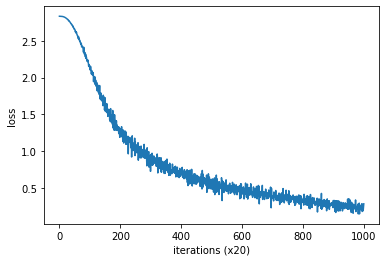

In [33]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'I like soccer but I have not play soccer. You are very exciting basketball player because You are nice face'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [34]:
# 学習済み重みパラメータを見てみる
word_vecs = model.word_vecs

for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

i [ 0.6097749  -3.1493602  -0.75918895 -0.26312768  1.8102301 ]
like [ 1.4184234  1.2361099 -1.5371615  1.2414654  1.4674406]
soccer [ 2.9283605 -1.7467073 -2.960654  -2.5136132 -1.5338169]
but [ 1.4501611   1.0510479  -0.11471695  1.9395049  -0.20296848]
have [ 1.5856143  1.2530556  2.3547957  1.3609055 -2.264198 ]
not [ 2.3605995 -1.3056164  1.7686068 -2.4470396  2.5558157]
play [ 2.2182832   2.0310576   0.10165245  1.1388326  -0.14102069]
. [ 0.27451193  0.00803026 -2.2123034   1.6443027   1.8276426 ]
you [-1.6289426  2.2514718 -1.0458579 -2.29439   -2.4768593]
are [-2.1125045  -2.6113813  -0.37105328  2.8677652   0.49933243]
very [-1.2112089   2.1958861   0.37542337 -1.8358229   0.5532861 ]
exciting [ 0.32555702 -2.660545    1.5998807   1.5455946  -2.9223595 ]
basketball [-1.4678179  2.1981611  1.7223603 -0.5036532  2.2458293]
player [-1.1770086 -2.1531217  2.4813752 -1.8637502 -2.3671596]
because [-2.105221    0.40867546 -2.0575197   2.061165    2.060829  ]
nice [-1.8011782   1.75

## 3.5 word2vecに関する補足

### 3.5.1 CBOWモデルと確率

#### CBOWモデルの式
## $$
   P(w_t|w_{t-1}, w_{t+1})
$$

意味：$w_{t-1}とw_{t+1}$が与えられたときに$w_t$が起こる確率

#### CBOWモデルの損失関数の式
## $$
   L = -\frac{1}{T}\sum_{t=1}^{T}logP(w_t|w_{t-1}, w_{t+1})
$$

### 3.5.2 skip-gramモデル

skip-gramはCBOWで扱うコンテキストとターゲットを逆転させたモデルである．したがって入力層が一つ，そして出力層はコンテキストの数だけ存在する．出力層では個別に損失を求め，それらを足し合わせたものを最終的な損失とする．

#### skip-gramの式
## $$
P(w_{t-1}, w_{t+1}|w_t)
$$

#### 意味
$w_t$が与えられたときに，$w_{t-1}$と$w_{t+1}$が同時に起こる確率

#### 条件付き独立
skip-gramモデルでは，コンテキストの単語の間に関連性がないと仮定して以下のように分解する．
## $$
P(w_{t-1}, w_{t+1}|w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)
$$

#### コーパス全体のskip-gramモデルの損失関数
## $$
L = -logP(w_{t-1}, w_{t+1}|w_t)
  = -logP(w_{t-1}|w_t)P(w_{t+1}|w_t)
  = -(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t))
$$

### 3.5.3 カウントベース v.s 推論ベース

## 3.6 まとめ

- 推論ベースの手法は，推測することを目標として，その副産物として単語の分散表現を得られる
- word2vecは推論ベースの手法であり，シンプルな2層のニューラルネットワークで構成される
- word2vecには，skig-gramモデルとCBOWモデルがある
- CBOWモデルは複数の単語（コンテキスト）から一つの単語（ターゲット）を推測する
- skip-gramモデルは逆に，一つの単語（ターゲット）から複数の単語（コンテキスト）を推測する
- word2vecは重みの再学習ができるため，単語の分散表現の更新や追加が効率的に行える